In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel, model
import geopandas as gpd
if manual:
    %matplotlib inline

PyTables is not installed. No support for HDF output.


In [3]:
training_folder = '../../'
input_folder = training_folder + r'inputs/'
plot_path = training_folder + 'outputs/plot/'

In [4]:
sm = stepmodel.read_zippedpickles(training_folder + 'models/base/base')

zones: 100%|██████████| 9/9 [00:00<00:00, 48.93it/s]


In [5]:
sm.nodes.index = sm.nodes['stop_id']

# add road

In [6]:
road_links = gpd.read_file(input_folder+'road/road_links.geojson', driver='GeoJSON')
road_nodes = gpd.read_file(input_folder+'road/road_nodes.geojson', driver='GeoJSON')
road_nodes.set_index('index', inplace=True)
sm.road_links = road_links
sm.road_nodes = road_nodes

In [7]:
road_links.head()

,index,a,b,length,geometry
0,6,125742,206155932,62.470,"LINESTRING (2.40137 48.85185, 2.40055 48.85171)"
1,7,125742,244455433,201.182,"LINESTRING (2.40137 48.85185, 2.40403 48.85233)"
2,8,125743,244455500,38.764,"LINESTRING (2.41341 48.85456, 2.41305 48.85431)"
3,9,125745,25245021,268.796,"LINESTRING (2.41435 48.85452, 2.41422 48.85694)"
4,10,125745,125743,73.156,"LINESTRING (2.41435 48.85452, 2.41341 48.85456)"


# road integrity

In [8]:
sm.integrity_fix_collision()

can not add prefixes on table:  footpaths


## road_fix

In [9]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)

direct: 6056it [00:00, 12979.87it/s]
reversed: 6056it [00:00, 14580.70it/s]
5738it [00:00, 13007.66it/s]


## road_test

In [10]:
sm.integrity_test_dead_ends()

5738it [00:00, 46955.16it/s]


In [11]:
sm.integrity_fix_nodeset_consistency()

In [12]:
sm.integrity_test_isolated_roads()

In [13]:
sm.integrity_test_road_duplicated_ab_links()

# Transport Integrity

## transport_fix

In [14]:
sm.integrity_fix_collision()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()

## transport_test

In [15]:
sm.integrity_fix_nodeset_consistency()

In [16]:
sm.integrity_test_circular_lines()
sm.integrity_test_collision()
sm.integrity_test_nodeset_consistency()
sm.integrity_test_sequences()

In [17]:
sm.integrity_test_all(errors='ignore')

passed: integrity_test_circular_lines
passed: integrity_test_collision


5738it [00:00, 37225.09it/s]

passed: integrity_test_dead_ends
passed: integrity_test_duplicate_volumes
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency


passed: integrity_test_road_duplicated_ab_links


5738it [00:00, 13770.70it/s]


passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences
passed: integrity_test_str_collision


In [18]:
sm = sm.change_epsg(epsg=3857, coordinates_unit='meter')

Reprojecting model from epsg 4326 to epsg 3857:   0%|          | 0/17 [00:00<?, ?it/s]

Reprojecting model from epsg 4326 to epsg 3857: 100%|██████████| 17/17 [00:01<00:00, 16.33it/s]


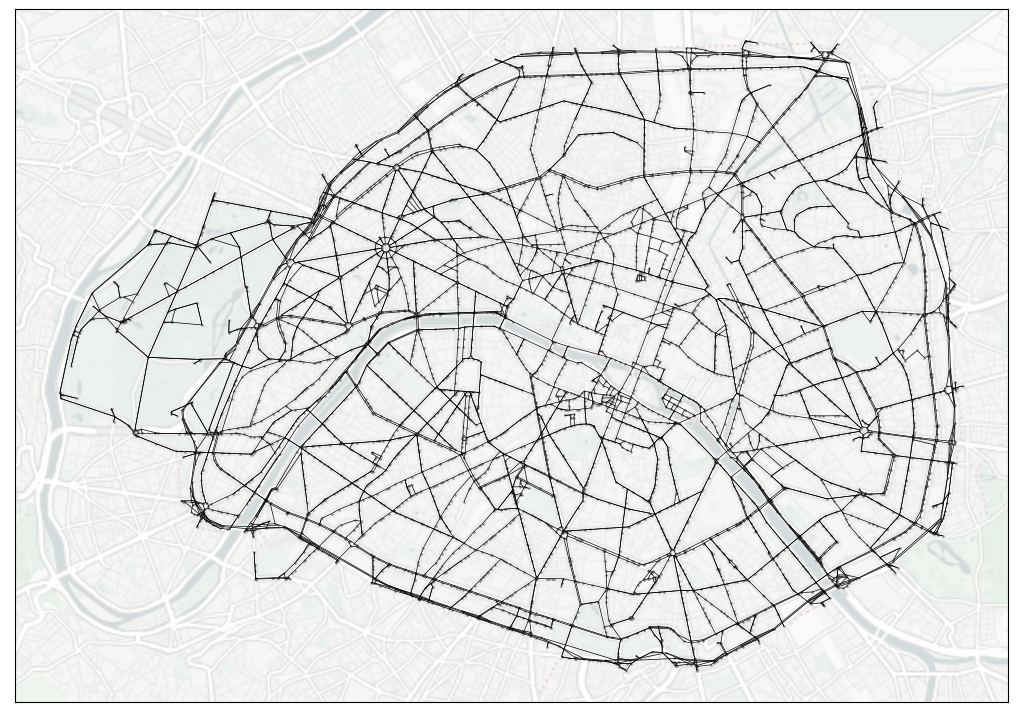

In [19]:
if manual:
    # pip install contextily required
    sm.plot(
        'road_nodes', color='grey', markersize=0.5,
        ax=sm.plot(
            'road_links', figsize=[16, 9], linewidth=0.5, color='black',
            basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png'
        ),    
    )

# to_zip

In [20]:
sm.to_zippedpickles(training_folder + 'models/base/networks')   

  0%|          | 0/17 [00:00<?, ?it/s]

orphan_nodes: 100%|██████████| 17/17 [00:00<00:00, 29.78it/s]


# END